### Questions Type Categories

Based on the previous notebook we are going to use convnets to perform question classification in this notebook. There will be little changes from the previous notebook but whenever there's a change i will highlight the change.

### You want to understand convnets in sequence data?
* Check this [pytorch notebook](https://github.com/CrispenGari/PyTorch-Python/blob/main/09_TorchText/02_Sentiment_Analyisis_Series/04_CNN_Sentiment_Analyisis.ipynb) out.

### Imports

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv, json, time
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

tf.__version__

'2.5.0'

### GPU

In [2]:
devices = tf.config.list_physical_devices("GPU")
try:
  tf.config.experimental.set_visible_devices(devices[0], "GPU")
  print("GPU set")
except RuntimeError as e:
  print(e)

GPU set


### SEED

In [3]:
SEED = 42
tf.random.set_seed(
    SEED
)
np.random.seed(SEED)

### Mounting the google drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

From the previous notebook we created the following files represending each set. This time we are going to load the data directly from these splitted csv files.

```
train.csv
test.csv
val.csv
```

In [5]:
data_path = os.path.join('/content/drive/MyDrive/NLP Data/questions-classification')
os.listdir(data_path)

['Question_Classification_Dataset.csv', 'val.csv', 'test.csv', 'train.csv']

### Loading the files

In [7]:
train_path = "train.csv"
test_path = "test.csv"
val_path = "val.csv"

train_dataframe = pd.read_csv(
    os.path.join(data_path, train_path)
)
val_dataframe = pd.read_csv(
    os.path.join(data_path, val_path)
)
test_dataframe = pd.read_csv(
    os.path.join(data_path, test_path)
)

### Question Classes

In [8]:
train_dataframe.Category0.unique()

array(['ENTITY', 'NUMERIC', 'HUMAN', 'LOCATION', 'DESCRIPTION',
       'ABBREVIATION'], dtype=object)

As you can see we have `6` different categories for these questions which are:
```
categories = ['ENTITY', 'DESCRIPTION', 'NUMERIC', 'HUMAN', 'LOCATION',
       'ABBREVIATION']
```

For now we are interested in the question and the class the question belongs to so we are going to target the following columns:

```
1. Questions
2. Category0
```

### Features and Labels

In [9]:
train_features = train_dataframe.Questions.values
train_labels = train_dataframe.Category0.values

test_features = test_dataframe.Questions.values
test_labels = test_dataframe.Category0.values

val_features = val_dataframe.Questions.values
val_labels = val_dataframe.Category0.values


### Label Encoding.

We are going to create encode the labels to numerical represantation using the `sklearn` `LabelEncoder` class.

In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)

LabelEncoder()

In [11]:
train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)
val_labels = label_encoder.transform(val_labels)

In [12]:
class_names = label_encoder.classes_
class_names 

array(['ABBREVIATION', 'DESCRIPTION', 'ENTITY', 'HUMAN', 'LOCATION',
       'NUMERIC'], dtype=object)

In [13]:
train_labels[:10]

array([2, 5, 3, 3, 3, 2, 5, 5, 3, 4])

### Next we are going to `one_hot_encode` labels.

We are only going to `one_hot` encode the train and validation labels. The test set we don't even care about it since we will be using it for model inference. I'm going to use the `numpy` method `eye`. You can use the `sklearn` ``OneHotEncoder`` class or the `tensorflow` method `one_hot`. To make this simple i will create a helper function that will encode the labels to one hot for me. I will then map through labels applying the `one_hot()` function to each label in the labels list.

In [14]:
def one_hot(index, depth=6): # 6 classes
  return np.eye(depth, dtype=np.float32)[index]

one_hot(2)

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [15]:
train_labels_one_hot = np.array(list(map(one_hot, train_labels)))
val_labels_one_hot = np.array(list(map(one_hot, val_labels)))

In [16]:
train_labels_one_hot[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

### Features

 For now we are done with labels. In our case our feature is a question. All we need to do in this dataset is to create a helper function that will convert the text to lower case that's all we need. 

 After that we will then prepare/preprocess the train and validation features for the model.

In [17]:
to_lower = lambda sent: sent.lower()

In [18]:
train_features = np.array(
    list(
        map(to_lower, train_features)
    )
)
val_features= np.array(
    list(
        map(to_lower, val_features)
    )
)

In [19]:
train_features[:2]

array(['what does salk vaccine prevent ?',
       "how many times a day should you take a prescription marked `` q.i.d . '' ?"],
      dtype='<U196')

### Preprocessing Features(Questions)

1. Create a vocabulary
2. Create a `stoi` from each sentencs
3. pad the sentences to have the same size

**Note** - During creation of the vocabulary we are going to use the `train` set. The model should not have an idea about the validation set, because we want the validation set to represent the test set as mush as possible.

### Vocab size, (aka) the number of unique words.

I'm going to use spacy to tokenize each sentence and then we count number of unique words in the train set.

In [20]:
from collections import Counter
from nltk.tokenize import word_tokenize

In [ ]:
import nltk
nltk.download('punkt')

In [22]:
train_features[0]

'what does salk vaccine prevent ?'

In [23]:
counter = Counter()
for sent in list(train_features):
  words = word_tokenize(sent)
  for word in words:
    counter[word] += 1
counter.most_common(9)

[('?', 3418),
 ('the', 2383),
 ('what', 2159),
 ('is', 1084),
 ('of', 988),
 ('in', 751),
 ('a', 675),
 ('how', 503),
 ("'s", 447)]

In [24]:
counter.most_common(20)

[('?', 3418),
 ('the', 2383),
 ('what', 2159),
 ('is', 1084),
 ('of', 988),
 ('in', 751),
 ('a', 675),
 ('how', 503),
 ("'s", 447),
 ('was', 416),
 ('to', 406),
 ('who', 399),
 (',', 370),
 ('for', 298),
 ('are', 275),
 ('and', 271),
 ('does', 255),
 ("''", 251),
 ('``', 249),
 ('did', 240)]

In [25]:
vocab_size = len(counter)
vocab_size

6568

We have `~6K` unique words in the train set. Next we are going to create word vectors.

### Word vectors

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [27]:
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_features)

In [28]:
word_indices = tokenizer.word_index
word_indices_reversed = dict([
    (v, k) for (k, v) in word_indices.items()
])

### Helper functions

We will create some helper function that converts sequences to text and text to sequences. These function will be used for inference later on.

In [29]:
def seq_to_text(sequences):
  return " ".join(word_indices_reversed[i] for i in sequences )

def text_to_seq(sent):
  words = word_tokenize(sent.lower())
  sequences = []
  for word in words:
    try:
      sequences.append(word_indices[word])
    except:
      sequences.append(0)
  return sequences

### Pretrained embeding weights

Since this model is using RNN's we are going to use the `pretrained glove.6B` word embeddings. I've already uploaded these word embedding on my google colab so that we can load them as follows

In [30]:
embedding_path = "/content/drive/MyDrive/NLP Data/glove.6B/glove.6B.100d.txt"


In [31]:
embedding_dict = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    embedding_dict[word] = vectors

In [32]:
print(len(embedding_dict))
embedding_dict["what"].shape

400000


(100,)

### But wait? `40000` words? Where are they comming from?
Okay don't panic we will create the embedding matrix that will suit our vocab_size next.

### Embedding matrix
We will then create an embedding matrix that will suit our data.

In [33]:
embedding_matrix = np.zeros((vocab_size, 100))

for word, index in word_indices.items():
  vector = embedding_dict.get(word)
  if vector is not None:
    try:
      embedding_matrix[index] = vector
    except IndexError or Exception:
      pass

In [34]:
len(embedding_matrix)

6568

Now the `embedding_matrix` suits our data which has `6592` words.

### Creating Sequences

In [35]:
train_sequences = tokenizer.texts_to_sequences(train_features)
val_sequences = tokenizer.texts_to_sequences(val_features)

In [36]:
val_sequences[0], val_features[0]

([2, 39, 3, 364, 36, 401], 'what city is served by tempelhol airport ?')

### Testing our helper functions

In [37]:
seq_to_text(val_sequences[0])

'what city is served by airport'

In [38]:
text_to_seq("this is why the unknownnnn word ?")

[456, 3, 45, 1, 0, 70, 0]

### Pad sequences

Our final step is to pad our suquences to have the same length. We are going to do this on the train and validation sets only.

In [39]:
max_words = 100

train_tokens_padded = pad_sequences(
    train_sequences, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)
val_tokens_padded = pad_sequences(
    val_sequences, 
    maxlen=max_words, 
    padding="post", 
    truncating="post"
)

### Building the model.

Unlike from the previous model we used bidirectional RNN, this time around we will be using the `Conv1D` layer and the apply the `GlobalAveragePooling1D()` so that we will be able to pass the output of the  `Conv1D` to dense layers that follows:


Model Achitecture.

````
                [ Embedding Layer]
                        |
                        |
                    [ Conv1D ]
                        |
                        |
                    [ Conv1D ]
                        |
                        |
                    [ Dropout ]
                        |
                        | 
                    [ Conv1D ]
                        |
                        |
                    [ Conv1D ]
                        |
                        |
                    [ Dropout ]
                        |
                        |
             [ GlobalAveragePooling1D]
                        |
                        |
                 [Dense Layer 1]
                        |
                        | 
                   [ Dropout ]
                        |
                        |   
                 [Dense Layer 2]
                        |
                        | 
                   [ Dropout ]
                        |
                        |
                 [Dense Layer 3] (output [6 classes])
````

This model achitecture will have ~70% less parameters that the previous model.

In [48]:
question_category_model = keras.Sequential([
      keras.layers.Embedding(
        vocab_size, 100, 
        input_length=max_words,
        weights=[embedding_matrix], 
        trainable=True,
        name = "embedding_layer"
      ),
      keras.layers.Conv1D(64, 3, 1, activation="relu", name="conv_layer_1"),
      keras.layers.Conv1D(512, 3, 1, activation="relu", name="conv_layer_2"),
      keras.layers.Dropout(rate= .5, name="dropout_layer_0_0"),
      keras.layers.Conv1D(512, 3, 1, activation="relu", name="conv_layer_3"),
      keras.layers.Conv1D(128, 3, 1, activation="relu", name="conv_layer_4"),
      keras.layers.Dropout(rate= .5, name="dropout_layer_0_1"),
      keras.layers.GlobalAveragePooling1D(name="pooling_layer"),
      keras.layers.Dense(64, activation='relu', name="dense_1"),
      keras.layers.Dropout(rate= .5, name="dropout_layer_0"),
      keras.layers.Dense(512, activation='relu', name="dense_2"),
      keras.layers.Dropout(rate= .5, name="dropout_layer_1"),
      keras.layers.Dense(6, activation='softmax', name="output"),
], name = "question_category_model")

question_category_model.summary()

Model: "question_category_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 100, 100)          656800    
_________________________________________________________________
conv_layer_1 (Conv1D)        (None, 98, 64)            19264     
_________________________________________________________________
conv_layer_2 (Conv1D)        (None, 96, 512)           98816     
_________________________________________________________________
dropout_layer_0_0 (Dropout)  (None, 96, 512)           0         
_________________________________________________________________
conv_layer_3 (Conv1D)        (None, 94, 512)           786944    
_________________________________________________________________
conv_layer_4 (Conv1D)        (None, 92, 128)           196736    
_________________________________________________________________
dropout_layer_0_1 (Dropout)  (None, 92, 128

### Compiling the model

Again we are going to compile our model and we will use the `EalyStopping` call back.

In [49]:
early_stopping = keras.callbacks.EarlyStopping(
     monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

question_category_model.compile(
    loss = keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer = keras.optimizers.Adam(1e-3, 0.5),
    metrics = ["accuracy"]
)

### How long should we train the model?
We are going to train the model for more epochs, as soon as the model loss stop decreasing we will stop.

In [50]:
EPOCHS = 50

history = question_category_model.fit(
    train_tokens_padded, train_labels_one_hot,
    validation_data = (
        val_tokens_padded, val_labels_one_hot
    ),
    verbose = 1,
    epochs = EPOCHS,
    batch_size = 64,
    shuffle = True,
    validation_batch_size = 16,
    callbacks = [early_stopping]
)

Epoch 1/50
55/55 [==============================] - 3s 37ms/step - loss: 1.6764 - accuracy: 0.2480 - val_loss: 1.6001 - val_accuracy: 0.3428
Epoch 2/50
55/55 [==============================] - 2s 31ms/step - loss: 1.6111 - accuracy: 0.2936 - val_loss: 1.5450 - val_accuracy: 0.3593
Epoch 3/50
55/55 [==============================] - 2s 32ms/step - loss: 1.4633 - accuracy: 0.3979 - val_loss: 1.3281 - val_accuracy: 0.4473
Epoch 4/50
55/55 [==============================] - 2s 32ms/step - loss: 1.2505 - accuracy: 0.4805 - val_loss: 1.2038 - val_accuracy: 0.5041
Epoch 5/50
55/55 [==============================] - 2s 32ms/step - loss: 1.0543 - accuracy: 0.5923 - val_loss: 1.3079 - val_accuracy: 0.4968
Epoch 6/50
55/55 [==============================] - 2s 31ms/step - loss: 0.8561 - accuracy: 0.6809 - val_loss: 1.0389 - val_accuracy: 0.6535
Epoch 7/50
55/55 [==============================] - 2s 32ms/step - loss: 0.6252 - accuracy: 0.7856 - val_loss: 0.9599 - val_accuracy: 0.6929
Epoch 8/50
55

### Evaluating the model.

We are going to evaluate the model on the test data. Remeber in the evaluate method we need to pass the data in the same shape we trained on so the test features and labels need to be processed.

### OneHot encode the test labels

In [51]:
test_labels_one_hot = np.array(list(map(one_hot, test_labels)))

### Converting test data to numeric and then pad it.

In [52]:
def text_to_padded_sequences(sent):
  tokens = text_to_seq(sent)
  padded_tokens = pad_sequences([tokens], maxlen=max_words, padding="post", truncating="post")
  return tf.squeeze(padded_tokens)

test_features_padded =  np.array(list(map(text_to_padded_sequences, test_features)))

question_category_model.evaluate(
    test_features_padded,
    test_labels_one_hot,
    verbose = 1,
    batch_size = 32
)

28/28 [==============================] - 0s 11ms/step - loss: 0.9738 - accuracy: 0.7686


[0.9737874865531921, 0.7686139941215515]

We got a loss of `~77%` which is `10%` lower to what we get from the previous notebook. This brings a conclusion that `RNN` are better when it comes to sequential data as compared to `ConvNets` 

### Model inference (making predictions)

In [53]:
from prettytable import PrettyTable

In [54]:
def tabulate(column_names, data, max_characters:int):
  table = PrettyTable(column_names)
  table.align[column_names[0]] = "l"
  table.align[column_names[1]] = "l"
  table.title = "QUESTION CLASSIFICATION PREDICTION TABLE"
  table._max_width = {column_names[0] :max_characters, column_names[1] :max_characters}
  for row in data:
    table.add_row(row)
  print(table)

In [55]:
def predict(model, sent, real_label=None):
  classes = class_names
  tokens = text_to_seq(sent)
  padded_tokens = pad_sequences([tokens], maxlen=max_words, 
                                padding="post", truncating="post")
  probabilities = model.predict(padded_tokens)
  prediction = tf.argmax(probabilities, axis=1).numpy()[0]
  class_name = classes[prediction]
  table_headers =["KEY", "VALUE"]
  table_data = [
        ["QUESTION", sent],
        ["PREDICTED CLASS",  prediction],
        ["PREDICTED CLASS NAME",  class_name],
        ["REAL CLASS",  real_label],
        ["REAL CLASS NAME",  classes[real_label]],
        ["CONFIDENCE OVER OTHER CLASSES", f'{probabilities[0][prediction] * 100:.2f}%'],
             
    ]
  tabulate(table_headers, table_data, 50)

### Making predictions on the test data.

In [56]:
for label, sent in zip(test_labels[:10], test_features[:10]):
  predict(question_category_model, sent, real_label=label)

+-------------------------------------------------------------------+
|              QUESTION CLASSIFICATION PREDICTION TABLE             |
+-------------------------------+-----------------------------------+
| KEY                           | VALUE                             |
+-------------------------------+-----------------------------------+
| QUESTION                      | How many wings does a flea have ? |
| PREDICTED CLASS               | 5                                 |
| PREDICTED CLASS NAME          | NUMERIC                           |
| REAL CLASS                    | 5                                 |
| REAL CLASS NAME               | NUMERIC                           |
| CONFIDENCE OVER OTHER CLASSES | 100.00%                           |
+-------------------------------+-----------------------------------+
+-----------------------------------------------------------+
|          QUESTION CLASSIFICATION PREDICTION TABLE         |
+-------------------------------+---

### Confusion matrix.

In [57]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes=None, figsize=(5, 5), text_size=20):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes.all():
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels,
          )
    ax.yaxis.label.set_color('green')
    ax.xaxis.label.set_color('green')


    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

In [58]:
predictions = tf.argmax(
    question_category_model(test_features_padded),
    axis=1
).numpy()

In [59]:
from matplotlib import pyplot as plt
class_names

array(['ABBREVIATION', 'DESCRIPTION', 'ENTITY', 'HUMAN', 'LOCATION',
       'NUMERIC'], dtype=object)

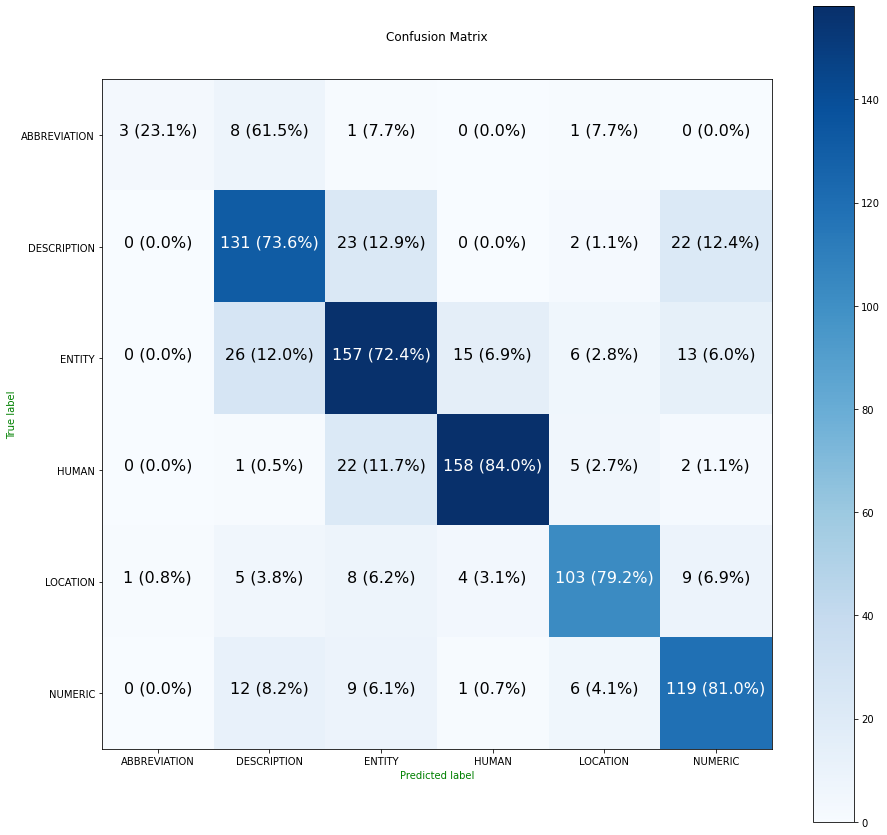

In [60]:
plot_confusion_matrix(test_labels, predictions, classes=class_names, figsize=(15, 15), text_size=16)

### Next.

Next we are going to use the same dataset to make predictions on two labels using `RNN's`